<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# State-of-the-art image similarity 

This notebook implements a state-of-the-art approach for image similarity.

We showed in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook how to train a DNN and use its feature embeddings for image retrieval. In that notebook, the DNN was trained using a standard image classification loss. More accurate models are typically trained explicitly for image similarity using Triplet Learning such as the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) paper. While triplet-based approaches achieve good accuracies, they are conceptually complex, slower, and more difficult to train/converge due to issue such as how to mine relevant triplets.

Instead, we implement the BMVC 2019 paper "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" which shows that this extra overhead is not necessary. Indeed, by making small changes to standard classification DNNs, the authors achieve results which are comparable or better than the previous state-of-the-art.


## Reproducing published results

### Datasets

Three common benchmark datasets were used to verify the correctness of this notebook, namely [CARS-196](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), [CUB-200-2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html), and [SOP](http://cvgl.stanford.edu/projects/lifted_struct/).

| Name | #classes  | #images |
| ---- | --------- | ------- |
| CUB-200-2011 |200| ~12,000 |
| CARS-196 | 196   | ~16,000 | 
| SOP  |22634      | ~120,000|


We follow the literature closely to replicate the same train/test splits and the same evaluation protocol as most publications (as described e.g. in this [paper](https://arxiv.org/abs/1511.06452)). For the datasets above, out of the total N classes, all images within the first N/2 classes are used for training and the remaining images are used for evaluation. This is an open-set evaluation setting where all images of a class are either fully assigned to training or to testing.

### Parameters

Our model matches that of the [paper](https://arxiv.org/abs/1811.12649): ResNet-50 architecture with 224 pixel input resolution and a temperature of 0.05. We train the head and the full DNN for 12 epochs each, with a learning rate of 0.01 and 0.0001 respectively. Similar to the paper, we decrease the learning rate by a factor of 10 for the CUB-200-2011 dataset to avoid overfitting. Note that competitive results can often be achieved using just half the number of epochs or less. All training uses fastai's `fit_one_cycle` policy.

### Re-ranking

Re-ranking is a post-processing step to improve retrieval accuracy. This notebook implements the CVPR 2017 paper [Re-Ranking Person Re-Identification With k-Reciprocal Encoding](https://arxiv.org/pdf/1701.08398.pdf). The proposed approach is fast, fully automatic, unsupervised, and shown to outperform other state-of-the-art methods with regards to accuracy.


### Results

As can be seen in the tables below, using this notebook (without re-ranking) we can re-produce the published accuracies. Our results for the CUB-200-2011 and the SOP datasets are close or even above the numbers in the paper; for CARS-196 however they are a few percentage points lower. It is worth pointing out the significant gain in accuracy for the SOP dataset compared to using the standard image classification loss in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook, i.e. from 57% to 80%.


Recall@1 using 2048 dimensional features:

|               |  CUB-200-2011 | CARS-196 | SOP |
| ------------- |  ------------ | -------- | --- |
| This notebook |         65%   | 84%      | 81% |
| Reported in paper|      65%   | 89%      | 80% | 


Recall@1 using 512 dimensional features:

|               |  CUB-200-2011 | CARS-196 | SOP |
| ------------- |  ------------ | -------- | --- |
| 01 notebook   |        53%    |    75%   | 57% |
| This notebook |        58%    |    78%   | 80% |
| Reported in paper|     61%    |    84%   | 78% | 

Finally, using the 4096 dimensional features from the pooling layer of our original ResNet-50 model, we can get a further boost of up to 2-3% compared to using 2048 dimensions:

|               |  CUB-200-2011 | CARS-196 | SOP |
| ------------- |  ------------ | -------- | --- |
| This notebook |         67%   |    87%   | 81% |


## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import math, os, random, sys, torch
import numpy as np
from pathlib import Path
import scrapbook as sb
import torch.nn as nn
from IPython.core.debugger import set_trace

# Fast.ai
import fastai
from fastai.layers import FlattenedLoss
from fastai.vision import (
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import Urls
from utils_cv.similarity.metrics import compute_distances
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import plot_distances
from utils_cv.similarity.references.evaluate import evaluate

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


## Data & Parameters

A small dataset is provided to run this notebook and to illustrate how the dataset is structured. The embedding dimension should be set to a value <= 2048 to use the pooling layer suggested in the paper, or to 4096 to use the original ResNet-50 pooling layer.

In [4]:
# Dataset
data_root_dir = unzip_url(Urls.fridge_objects_retrieval_path, exist_ok = True)
DATA_FINETUNE_PATH = os.path.join(data_root_dir, "train")
DATA_RANKING_PATH = os.path.join(data_root_dir, "test")
print("Image root directory: {}".format(data_root_dir))

# DNN configuration and learning parameters. Use more epochs to possibly improve accuracy.
EPOCHS_HEAD = 6 #12 
EPOCHS_BODY = 6 #12
HEAD_LEARNING_RATE = 0.01   
BODY_LEARNING_RATE = 0.0001 
BATCH_SIZE = 32
IM_SIZE = (224,224)
DROPOUT = 0 
ARCHITECTURE = models.resnet50

# Desired embedding dimension. Higher dimensions slow down retrieval but often provide better accuracy.
EMBEDDING_DIM = 2048
assert EMBEDDING_DIM == 4096 or EMBEDDING_DIM <= 2048 

Image root directory: C:\Users\pabuehle\Desktop\computervision-recipes\data\fridgeObjectsImageRetrieval


Most images are used for training, and only a small percentage for validation to obtain a rough estimate of the validation loss. We use the standard image augmentations specified by fastai's `get_transforms()` function which includes horizontal flipping, image warping and changing pixel intensities.

Data for fine-tuning: 62 training images and 3 validation images.


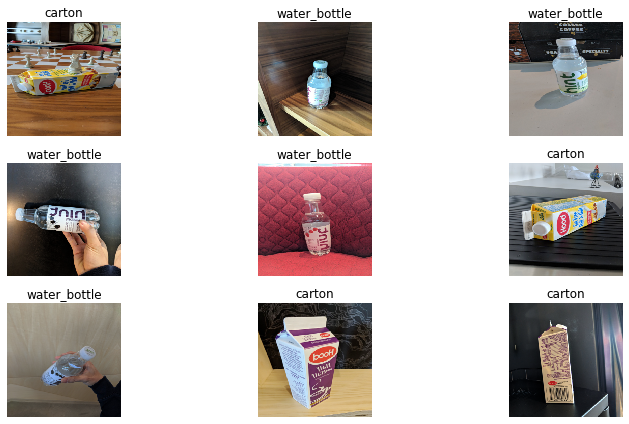

In [5]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data_finetune = (
    ImageList.from_folder(DATA_FINETUNE_PATH)
    .split_by_rand_pct(valid_pct=0.05, seed=20)
    .label_from_folder()
    .transform(tfms=fastai.vision.transform.get_transforms(), size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"Data for fine-tuning: {len(data_finetune.train_ds.x)} training images and {len(data_finetune.valid_ds.x)} validation images.")

data_finetune.show_batch(rows=3, figsize=(12, 6))

## NormSoftmax layers and loss 

The cell below implements the NormSoftmax loss and layers from the "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" paper. Most of the code is taken from the [official repository](https://github.com/azgo14/classification_metric_learning) and only slightly modified to work within the fast.ai framework and to optionally use the 4096 dimensional embedding of the original ResNet-50 model.

In [6]:
class EmbeddedFeatureWrapper(nn.Module):
    """
    DNN head: pools, down-projects, and normalizes DNN features to be of unit length.
    """
    def __init__(self, input_dim, output_dim, dropout=0):
        super(EmbeddedFeatureWrapper, self).__init__()
        self.output_dim = output_dim
        self.dropout = dropout
        if output_dim != 4096:
            self.pool = nn.AdaptiveAvgPool2d(1)
        self.standardize = nn.LayerNorm(input_dim, elementwise_affine = False)
        self.remap = None
        if input_dim != output_dim:
           self.remap = nn.Linear(input_dim, output_dim, bias = False)
        if dropout > 0:
            self.dropout = nn.Dropout(dropout) 
    
    def forward(self, x):
        if self.output_dim != 4096:
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.standardize(x)
        if self.remap:
           x = self.remap(x)
        if self.dropout > 0:
            x = self.dropout(x)      
        x = nn.functional.normalize(x, dim=1)
        return x
    
    
class L2NormalizedLinearLayer(nn.Module):
    """
    Apply a linear layer to the input, where the weights are normalized to be of unit length.
    """
    def __init__(self, input_dim, output_dim):
        super(L2NormalizedLinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim))    
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        # Initialization from nn.Linear (https://github.com/pytorch/pytorch/blob/v1.0.0/torch/nn/modules/linear.py#L129)
        
    def forward(self, x):
        norm_weight = nn.functional.normalize(self.weight, dim=1)
        prediction_logits = nn.functional.linear(x, norm_weight)
        return prediction_logits
        

class NormSoftmaxLoss(nn.Module):
    """
    Apply temperature scaling on logits before computing the cross-entropy loss.
    """
    def __init__(self, temperature=0.05):
        super(NormSoftmaxLoss, self).__init__() 
        self.temperature = temperature
        self.loss_fn = nn.CrossEntropyLoss()
 
    def forward(self, prediction_logits, instance_targets):
        loss = self.loss_fn(prediction_logits / self.temperature, instance_targets)
        return loss

## Modified classification DNN

We begin by retrieving a pre-trained [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which was trained on ImageNet. 

In [7]:
learn = cnn_learner(
    data_finetune,
    ARCHITECTURE,
    metrics=[],
    ps=DROPOUT 
)

print("** Original model head **")
print(learn.model[1])

** Original model head **
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=2, bias=True)
)


The CNN is then modified to use the suggested "norm softmax loss" instead of the default cross-entropy loss:

In [8]:
# By default uses the 2048 dimensional pooling layer as implemented in the paper.
# Optionally can instead keep the 4096-dimensional pooling layer from the ResNet-50 model.
if EMBEDDING_DIM != 4096:
    modules = []
    pooling_dim = 2048
else:
    modules = [l for l in learn.model[1][:3]]
    pooling_dim = 4096
    
# Add new layers
modules.append(EmbeddedFeatureWrapper(input_dim=pooling_dim, 
                                      output_dim=EMBEDDING_DIM, 
                                      dropout=DROPOUT))
modules.append(L2NormalizedLinearLayer(input_dim=EMBEDDING_DIM, 
                                       output_dim=len(data_finetune.classes)))
learn.model[1] = nn.Sequential(*modules)

# Create new learner object since otherwise the new layers are not updated during backprop 
learn = fastai.vision.Learner(data_finetune, learn.model)

# Update loss function
learn.loss_func = FlattenedLoss(NormSoftmaxLoss)

print("\n** Edited model head **")
print(learn.model[1])


** Edited model head **
Sequential(
  (0): EmbeddedFeatureWrapper(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (standardize): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
  )
  (1): L2NormalizedLinearLayer()
)


## Run DNN training

Similar to the [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks) we first refine the head and then the full CNN.

In [9]:
learn.fit_one_cycle(EPOCHS_HEAD, HEAD_LEARNING_RATE) 

epoch,train_loss,valid_loss,time
0,0.853712,0.736492,00:05
1,0.728963,0.103591,00:01
2,0.501936,0.083357,00:01
3,0.377305,0.037129,00:01
4,0.300256,0.018464,00:01
5,0.248494,0.016273,00:01


Let's now unfreeze all the layers and fine-tuning the model more.


In [10]:
learn.unfreeze()


In [11]:
learn.fit_one_cycle(EPOCHS_BODY, BODY_LEARNING_RATE)

epoch,train_loss,valid_loss,time
0,0.001476,0.017615,00:01
1,0.002136,0.002126,00:01
2,0.001491,0.000432,00:01
3,0.001192,0.000137,00:01
4,0.000980,0.000093,00:01
5,0.000819,0.000124,00:01


## Feature extraction

We now load the ranking set which is used to evaluate image retrieval performance.

Data for retrieval evaluation: 69 images.


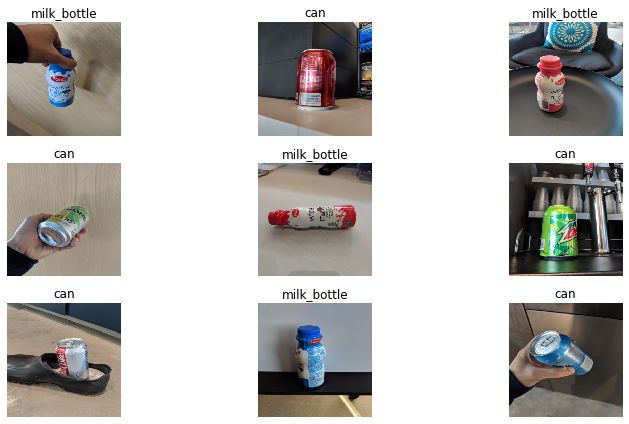

In [12]:
# Load images into fast.ai's ImageDataBunch object
data_rank = (
    ImageList.from_folder(DATA_RANKING_PATH)
    .split_none()
    .label_from_folder()
    .transform(size=IM_SIZE) 
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"Data for retrieval evaluation: {len(data_rank.train_ds.x)} images.")

# Display example images
data_rank.show_batch(rows=3, figsize=(12, 6))

The following line will allow us to extract the DNN features after running each image through the model.

In [13]:
#Compute DNN features for all validation images
embedding_layer = learn.model[1][-2]
dnn_features = compute_features_learner(data_rank, DatasetType.Train, learn, embedding_layer)

## Image Retrieval Example
The cell below shows how to find and display the most similar images in the ranking set for a given query image (which we also select from the ranking set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook.

Query image path: C:\Users\pabuehle\Desktop\computervision-recipes\data\fridgeObjectsImageRetrieval\test\can\10.jpg
Query feature dimension: 2048


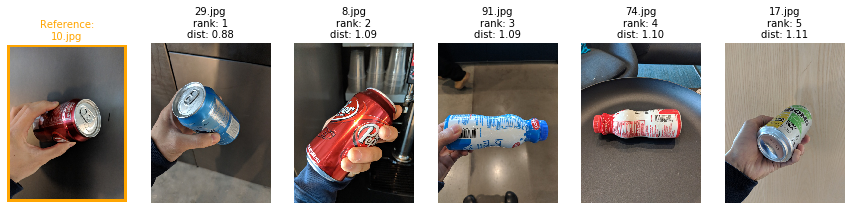

In [14]:
# Get the DNN feature for the query image
query_im_path =  str(data_rank.train_ds.items[1])
query_feature = dnn_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == EMBEDDING_DIM

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, dnn_features)
plot_distances(distances, num_rows=1, num_cols=6, figsize=(15,5))

## Quantitative evaluation

Finally, to quantitatively evaluate image retrieval performance, we compute the Recall@1 measure. The implementation below is slow but straight-forward and shows the usage of the `compute_distances()` function.

Note that the "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" paper uses the cosine distance, while we interchangably use either the dot product or the L2 distance. This is possible since all DNN features are L2-normalized and hence both distance metrics return the same ranking order (see: https://en.wikipedia.org/wiki/Cosine_similarity).


### Slow approach

Below shows how one would intuitively implement the rank@1 measure. Note that this implementation uses our `compute_distances()` function and especially for large datasets is too slow due to the nested loops. For large datasets hence only a subset of around 500 queries is used. 

In [15]:
#init
count = 0
labels = data_rank.train_ds.y
im_paths = data_rank.train_ds.items
assert len(labels) == len(im_paths) == len(dnn_features)

# Use a subset of at least 500 images from the ranking set as query images.
step = math.ceil(len(im_paths)/500.0)
query_indices = range(len(im_paths))[::step]

# Loop over all query images
for query_index in query_indices:
    if query_index+1 % (step*100) == 0:
        print(query_index, len(im_paths))

    # Get the DNN features of the query image
    query_im_path =  str(im_paths[query_index])
    query_feature = dnn_features[query_im_path]
    
    # Compute distance to all images in the gallery set. 
    distances = compute_distances(query_feature, dnn_features)

    # Find the image with smallest distance
    min_dist = float('inf')
    min_dist_index = None
    for index, distance in enumerate(distances):
        if index != query_index: #ignore the query image itself
            if distance[1] < min_dist:
                min_dist = distance[1]
                min_dist_index = index

    # Count how often the image with smallest distance has the same label as the query
    if labels[query_index] == labels[min_dist_index]:
        count += 1

In [16]:
recallAt1 = 100.0 * count / len(query_indices)
print("Recall@1 = {:2.2f}".format(recallAt1))

Recall@1 = 92.75


In [17]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("recallAt1", recallAt1)

### Fast approach with re-ranking

Below is a much more efficient computation of different rank@n metrics and of the mean average-precision metric.

In [18]:
ranks, mAP = evaluate(data_rank.train_ds, dnn_features, use_rerank = False)

Rank@1:92.8, rank@5:100.0, rank@10:100.0, mAP:0.75


The function also supports **re-ranking** to improve accuracy. Re-ranking is introduced at the top of this notebook, and in our experience can dramatically boost mAP, with less of an influence on rank@1. See the [code](../../utils_cv/similarity/references/re_ranking.py) and the [paper](https://arxiv.org/pdf/1701.08398.pdf) for more information and for a discussion of the three main paramters: k1, k2, and lambda. By default we use k1=20, k2=6, and lambda=0.3 as suggested in the paper and shown to work well on four different datasets. We suggest however to fine-tune these parameters to obtain maximum accuracy improvement.   

In [19]:
ranks, mAP = evaluate(data_rank.train_ds, dnn_features, use_rerank = True)

Calculate re-ranked distances..
Reranking complete in 0m 0s
Rank@1:95.7, rank@5:100.0, rank@10:100.0, mAP:0.83
